In [12]:
import torch
from gan_evaluation import generate_images, pca_images, plot_pca
from utils import get_dataset_custom_training
from CGAN_PyTorch.cgan_pytorch.models.generator import Generator
from CGAN_PyTorch.cgan_pytorch.models.generator import ConvGenerator
from torch.utils.data import DataLoader
import os
from tqdm import tqdm
from src.gan_evaluation import classifier_accuracy, load_classifier, calculate_emd


# Load the MNIST dataset
_, test_dataset = get_dataset_custom_training('mnist')
testloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [13]:
# Initialize the Generator
generator = Generator()
# Load the trained model weights
generator.load_state_dict(torch.load(os.path.join('..', 'weights', 'CGAN_20240529-163324.pth')))
generator.eval()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator.to(device)

Generator(
  (label_embedding): Embedding(10, 10)
  (main): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

Testing: 100%|██████████| 313/313 [00:03<00:00, 99.73it/s] 


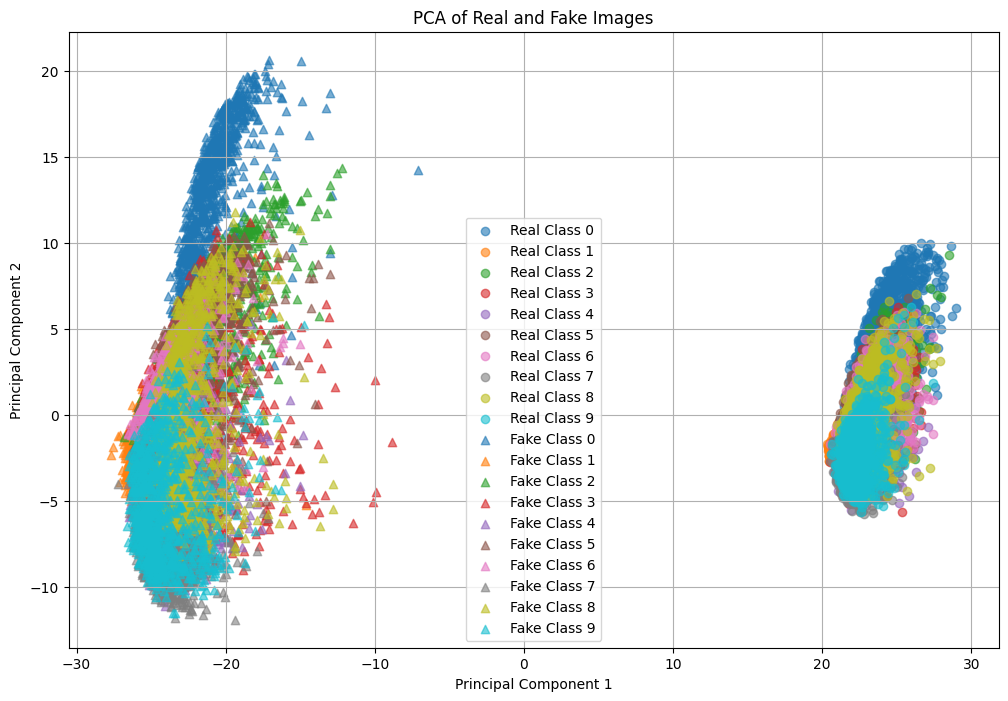

Earth Mover's Distance: 1.74473777050194
Real images accuracy: 0.9913, Fake images accuracy: 0.9519


In [14]:
real_preds = 0
fake_preds = 0
emd_real_images = torch.empty(0, ).to(device)
emd_fake_images = torch.empty(0, ).to(device)
labels_list = torch.empty(0, ).to(device)

model = load_classifier('mnist', model_path=os.path.join('..', 'weights', 'mnist_classifier.pth'))
for batch_idx, (images, labels) in enumerate(tqdm(testloader, f"Testing: ")):
    images = images.to(device)
    labels = labels.to(device)
    fake_images = generate_images(generator, device, labels, num_images=images.size(0), latent_dim=100,
                                  num_classes=10)
    emd_real_images = torch.cat((emd_real_images, images), dim=0)
    emd_fake_images = torch.cat((emd_fake_images, fake_images), dim=0)
    labels_list = torch.cat((labels_list, labels), dim=0)
    real_preds_temp, fake_preds_temp = classifier_accuracy(model, images, fake_images, labels, 'mnist',
                                                           device)
    real_preds += real_preds_temp
    fake_preds += fake_preds_temp

real_accuracy = real_preds / len(test_dataset)
fake_accuracy = fake_preds / len(test_dataset)

emd = calculate_emd(emd_real_images, emd_fake_images)
# pca_real, pca_fake = pca_images(emd_real_images, emd_fake_images)
# plot_pca(pca_real, pca_fake, labels_list)
print(f"Earth Mover's Distance: {emd}")
print(f"Real images accuracy: {real_accuracy}, Fake images accuracy: {fake_accuracy}")